In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler

from imblearn.under_sampling import RandomUnderSampler

import joblib


In [2]:
df = pd.read_csv('/home/wahba/Documents/dataset/processed/2_cicids2017_benign_attack.csv')

selected_features = [
    # Flow-level
    'Flow Duration',
    'Flow Packets/s',
    'Flow Bytes/s',
    'Flow IAT Mean',
    'Flow IAT Max',
    'Flow IAT Std',
    
    # Forward features
    'Fwd Header Length',
    'Fwd IAT Total',
    'Fwd IAT Mean',
    'Fwd IAT Max',
    'Fwd IAT Std',
    'Fwd Packet Length Min',
    'Fwd Packet Length Max',
    'Fwd Packet Length Mean',
    'Fwd Packet Length Std',
    'Subflow Fwd Bytes',
    'Total Fwd Packets',
    'Total Length of Fwd Packets',
    
    # Backward features
    'Bwd Header Length',
    'Bwd Packet Length Min',
    'Bwd Packet Length Max',
    'Bwd Packet Length Std',
    'Bwd Packets/s',
    'Init_Win_bytes_backward',
    
    # Packet-level
    'Packet Length Mean',
    'Packet Length Std',
    'Packet Length Variance',
    'Average Packet Size',
    'PSH Flag Count',
    'Init_Win_bytes_forward',
    'Max Packet Length',

    'Label',
]

# Keep only the selected features
df = df[selected_features]

# 1.0 Dataset Preparation

## 1.1 Training and Testing Dataset Splitting

In [3]:
# splitting df for training and testing using stratified split
X = df.drop('Label', axis=1) # features
y = df['Label'] # target

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

X_train = strat_train_set.drop("Label", axis=1)
y_train = strat_train_set["Label"]

X_test = strat_test_set.drop("Label", axis=1)
y_test = strat_test_set["Label"]

label_mapping = {'Benign': 0, 'Attack': 1}
y_train = y_train.map(label_mapping)
y_test  = y_test.map(label_mapping)

print(pd.DataFrame({
    "count (df)": df["Label"].value_counts(),
    "count (train_set)": strat_train_set["Label"].value_counts(),
    "count (test_set)": strat_test_set["Label"].value_counts(),
    "proportion": strat_train_set["Label"].value_counts(normalize=True),
})
)

        count (df)  count (train_set)  count (test_set)  proportion
Label                                                              
Benign     2096484            1677187            419297    0.831159
Attack      425878             340702             85176    0.168841


## 1.2 Feature Scaling for KNN using Robust Scaler

In [4]:
rbscaler = RobustScaler()

# fit and transform training data, transform testing data
X_train_scaled = rbscaler.fit_transform(X_train)
X_test_scaled = rbscaler.transform(X_test)

print(pd.DataFrame({
    "count": y_train.value_counts(),
    "proportion": y_train.value_counts(normalize=True)
})
)

joblib.dump(rbscaler, '/home/wahba/Documents/model/binary_classification/robust_scaler.joblib')

         count  proportion
Label                     
0      1677187    0.831159
1       340702    0.168841


['/home/wahba/Documents/model/binary_classification/robust_scaler.joblib']

## 1.3 Undersampling Benign class

In [5]:
attack_count = y_train[y_train == 1].shape[0]

rus = RandomUnderSampler(
    sampling_strategy={0: attack_count},
    random_state=42
)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
X_train_scaled_resampled, y_train_scaled_resampled = rus.fit_resample(X_train_scaled, y_train)

print(pd.DataFrame({
    "count": y_train_resampled.value_counts(),
    "proportion": y_train_resampled.value_counts(normalize=True)
})
)

        count  proportion
Label                    
0      340702         0.5
1      340702         0.5


# 2.0 Machine Learning Training

## 2.1. Random Forest

In [6]:
# rf = RandomForestClassifier(n_estimators=150, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', max_depth=30, random_state=42, n_jobs=-1)
# rf.fit(X_train_resampled, y_train_resampled)
# cv_scores_rf = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=5, n_jobs=-1)
# joblib.dump(rf, '/home/wahba/Documents/model/binary_classification/rf_binary.joblib')

['/home/wahba/Documents/model/binary_classification/rf_binary.joblib']

## 2.2. XGBoost

In [21]:
xgb = xgb.XGBClassifier(
    subsample=1.0, 
    n_estimators=100, 
    min_child_weight=1, 
    max_depth=6, 
    learning_rate=0.2, 
    colsample_bytree=1.0, 
	objective='binary:logistic',
    random_state=42,
    n_jobs=-1)

xgb.fit(X_train_resampled, y_train_resampled)
cv_scores_xgb = cross_val_score(xgb, X_train_resampled, y_train_resampled, cv=5, n_jobs=-1)
joblib.dump(xgb, '/home/wahba/Documents/model/binary_classification/xgb_binary.joblib')

/home/wahba/miniconda3/envs/ml1/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/wahba/miniconda3/envs/ml1/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' varia

['/home/wahba/Documents/model/binary_classification/xgb_binary.joblib']

## 2.3. K-Nearest Neighbour (KNN)

In [22]:
knn = KNeighborsClassifier(weights='distance', n_neighbors=3, n_jobs=-1)
knn.fit(X_train_scaled, y_train)

# Perform cross-validation
cv_scores_knn = cross_val_score(knn, X_train_scaled_resampled, y_train_scaled_resampled, cv=5, n_jobs=-1)
joblib.dump(knn, '/home/wahba/Documents/model/binary_classification/knn_binary.joblib')

['/home/wahba/Documents/model/binary_classification/knn_binary.joblib']

# 3.0 Model Evaluation


            === Model 1 Evaluation ===
          
Cross-Validation Scores:
CV Scores: [0.99798211 0.99818757 0.99824627 0.99790139 0.99807749]
Mean CV Score: 0.9981 (+/- 0.0003)

=== Test Set Performance ===
Accuracy: 0.9978
Precision: 0.9886
Recall: 0.9984
F1 Score: 0.9935
ROC-AUC: 0.9999
Average Precision (PR-AUC): 0.9997

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    419297
           1       0.99      1.00      0.99     85176

    accuracy                           1.00    504473
   macro avg       0.99      1.00      1.00    504473
weighted avg       1.00      1.00      1.00    504473


=== Confusion Matrix ===
[[418320    977]
 [   136  85040]]


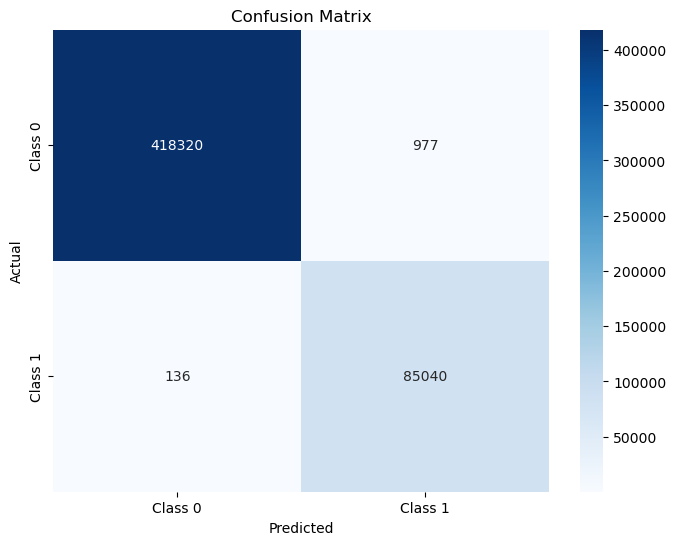

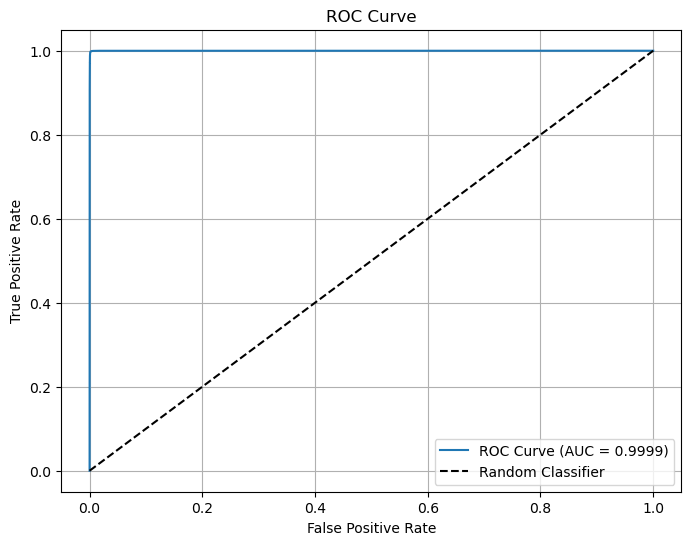


=== Training vs Test Performance ===
Training Accuracy: 0.9990
Test Accuracy: 0.9978
Training F1: 0.9990
Test F1: 0.9935

            === Model 2 Evaluation ===
          
Cross-Validation Scores:
CV Scores: [0.99809951 0.99827562 0.9982316  0.99848842 0.99834899]
Mean CV Score: 0.9983 (+/- 0.0003)

=== Test Set Performance ===
Accuracy: 0.9978
Precision: 0.9878
Recall: 0.9993
F1 Score: 0.9935
ROC-AUC: 0.9999
Average Precision (PR-AUC): 0.9997

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    419297
           1       0.99      1.00      0.99     85176

    accuracy                           1.00    504473
   macro avg       0.99      1.00      1.00    504473
weighted avg       1.00      1.00      1.00    504473


=== Confusion Matrix ===
[[418246   1051]
 [    62  85114]]


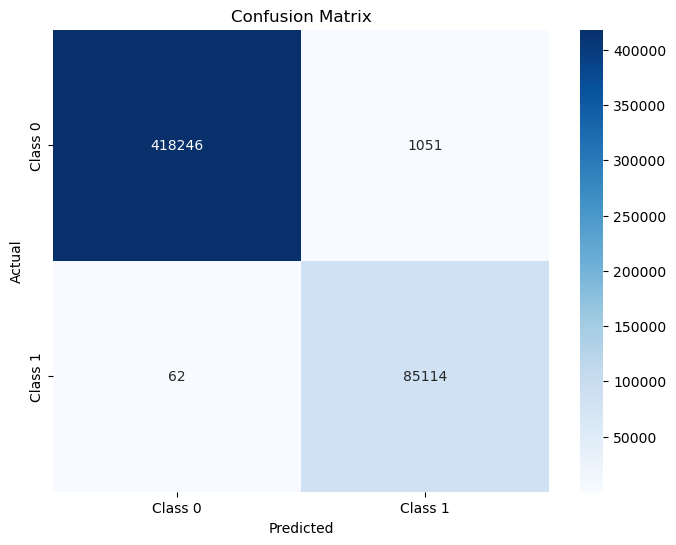

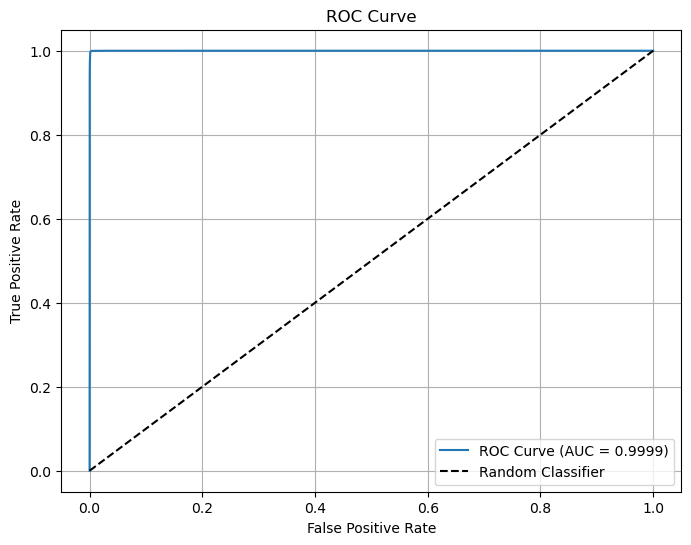


=== Training vs Test Performance ===
Training Accuracy: 0.9986
Test Accuracy: 0.9978
Training F1: 0.9986
Test F1: 0.9935

            === Model 3 Evaluation ===
          
Cross-Validation Scores:
CV Scores: [0.97847095 0.97954961 0.97922674 0.98083372 0.98224244]
Mean CV Score: 0.9801 (+/- 0.0027)


In [ ]:
models = [rf, xgb, knn]
cv_scores = [cv_scores_rf, cv_scores_xgb, cv_scores_knn]

for i in range(len(models)): 
    # 1. Cross-validation scores (you already have this)
    print(f'''
            ===============================
            === Model {i+1} Evaluation ===
            ===============================
          ''')
    print("Cross-Validation Scores:")
    print(f"CV Scores: {cv_scores[i]}")
    print(f"Mean CV Score: {cv_scores[i].mean():.4f} (+/- {cv_scores[i].std() * 2:.4f})")

    # 2. Predictions on test set
    y_pred = models[i].predict(X_test if i != 2 else X_test_scaled)  # Use scaled data for KNN
    y_pred_proba = models[i].predict_proba(X_test if i != 2 else X_test_scaled)[:, 1]  # Probabilities for positive class

    # 3. Basic metrics
    print("\n=== Test Set Performance ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    print(f"Average Precision (PR-AUC): {average_precision_score(y_test, y_pred_proba):.4f}")

    # 4. Classification report (detailed per-class metrics)
    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred))

    # 5. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\n=== Confusion Matrix ===")
    print(cm)
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    # 6. ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 7. Compare training vs test performance (check for overfitting)
    y_train_pred = models[i].predict(X_train_resampled if i != 2 else X_train_scaled_resampled)
    print("\n=== Training vs Test Performance ===")
    print(f"Training Accuracy: {accuracy_score(y_train_resampled, y_train_pred):.4f}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Training F1: {f1_score(y_train_resampled, y_train_pred):.4f}")
    print(f"Test F1: {f1_score(y_test, y_pred):.4f}")